In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.sparse as spr
%matplotlib inline

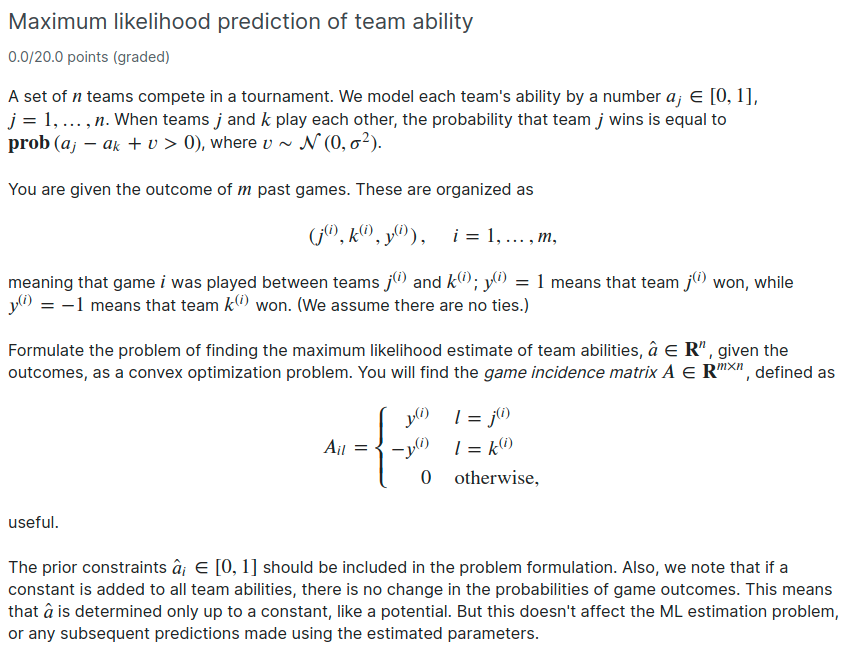

# Formulation

$P(a | data) = \prod_{j,k | j \rightarrow k}{P(-v < a_j - a_k)}
= \prod_{j,k | j \rightarrow k}{P(Z < \frac{a_j - a_k}{\sigma})} \quad, Z = N(0,1)  \newline
= \prod_{j,k | j \rightarrow k}{F_Z(\frac{a_j - a_k}{\sigma}))}
$

$log P(a|data) = \sum_{j,k | j \rightarrow k}{log(F_Z(\frac{a_j - a_k}{\sigma}))}
= log(F_Z(\frac{Aa}{\sigma}))^T 1$

F_Z is log-concave $\implies log(F_Z(\frac{Aa}{\sigma}))^T 1$ is concave. 

---
maximize $log(F_Z(\frac{Aa}{\sigma}))^T 1$  
s.t  
$0 \leq a \leq 1$

# Problem data

In [2]:
train = np.loadtxt("outcomes_train.txt", dtype = int)
test = np.loadtxt("outcomes_test.txt", dtype = int)

In [3]:
n = 10;
m = len(train)
m_test = len(test)
sigma = 0.250;
n, m

(10, 45)

# Solving

In [4]:
def build_A(outcomes, n):
    m = len(outcomes)
    A = spr.csr_matrix((outcomes[:,2], (range(m), outcomes[:,0] - 1)), shape = (m,n))
    B = spr.csr_matrix((-outcomes[:,2],(range(m), outcomes[:,1] - 1)), shape = (m,n))
    return A+B

In [5]:
a = cp.Variable(n, nonneg = True)
A = build_A(train, n)
log_prob = cp.sum(cp.log_normcdf((A@a)/sigma))
C = [a <= 1]
prob = cp.Problem(cp.Maximize(log_prob), C)
prob.solve()
assert prob.status == cp.OPTIMAL
print(prob.value)
print(a.value)

-11.430294646964972
[1.         0.         0.67827377 0.36870462 0.79002166 0.58130641
 0.38738245 0.08544141 0.67004625 0.57748618]


Evaluation on test data

In [6]:
r = a.value
y_pred = np.sign(r[test[:,0]-1] - r[test[:,1]-1])
y_true = test[:,2]
(y_pred == y_true).mean().round(4)

0.8667

Baseline : same results of train data (last year)

In [7]:
assert (test[:,[0,1]] == train[:,[0,1]]).all()
y_pred = train[:,2]
(y_pred == y_true).mean().round(4)

0.7556